In [1]:
import sys
sys.path.insert(0, '../')

import matplotlib.pyplot as plt
import numpy as np

import networkx as nx

from ase import Atoms
from ase.io import read, write
from ase.optimize import BFGS

from scipy.optimize import curve_fit, minimize

from cgf.cycles import find_cycles, cycle_graph
from cgf.motifs import find_unique_motifs
from cgf.utils import remove_hatoms
from cgf.baff import BAFFPotential
from cgf.bnff import MikadoPotential, _energy_total, _get_phi0

In [2]:
# s0 = read('../test-data/opt_SW.gen', index=-1)
# s0 = read('../test-data/Tp_lc2_1Phenyl_opt_SW.gen', index=-1)
s0 = read('../test-data/Star_COF_1phenyl_SW_opt.gen', index=-1)

remove_hatoms(s0)

cy = find_cycles(s0)

G_cy = cycle_graph(cy, s0.positions)

for n in G_cy.nodes:
    G_cy.nodes[n]['cl'] = len(G_cy.nodes[n]['cycle'])

237


In [3]:
# Star and DB2 COF
motif = nx.Graph()
motif.add_edge("A", "D1")
motif.add_edge("A", "E1")
motif.add_edge("B", "D3")
motif.add_edge("B", "F1")
motif.add_edge("C", "F3")
motif.add_edge("C", "E3")

motif.add_edge("D1", "D2")
motif.add_edge("D2", "D3")
motif.add_edge("E1", "E2")
motif.add_edge("E2", "E3")
motif.add_edge("F1", "F2")
motif.add_edge("F2", "F3")

# Star COF
for n in motif.nodes:
    motif.nodes[n]['cl'] = 6
motif.nodes['D2']['cl'] = 2
motif.nodes['E2']['cl'] = 2
motif.nodes['F2']['cl'] = 2

# DB2 COF
# for n in motif.nodes:
#     motif.nodes[n]['cl'] = 2
# motif.nodes['A']['cl'] = 6
# motif.nodes['B']['cl'] = 6
# motif.nodes['C']['cl'] = 6


mfs = find_unique_motifs(motif, G_cy)
print(len(mfs))


r_c = []
phi_c = []
for m in mfs:
    r_B = G_cy.nodes[m['B']]['pos'].mean(axis=0)
    r_A = G_cy.nodes[m['A']]['pos'].mean(axis=0)
    r_C = G_cy.nodes[m['C']]['pos'].mean(axis=0)

    r_c.append((r_A + r_B + r_C)/3)
    r_AB = r_A - (r_A + r_B + r_C)/3
    phi_c.append(np.arctan2(r_AB[1], r_AB[0]))
    
r_c = np.array(r_c)
phi_c = np.array(phi_c)

108
18


In [18]:
# Tp COF
motif = nx.Graph()
motif.add_edge("A", "B")
motif.add_edge("C", "B")
motif.add_edge("D", "B")

motif.nodes['A']['cl'] = 6
motif.nodes['B']['cl'] = 6
motif.nodes['C']['cl'] = 6
motif.nodes['D']['cl'] = 6

mfs = find_unique_motifs(motif, G_cy)
print(len(mfs))

r_c = np.array([G_cy.nodes[m['B']]['pos'].mean(axis=0) for m in mfs])

108
18


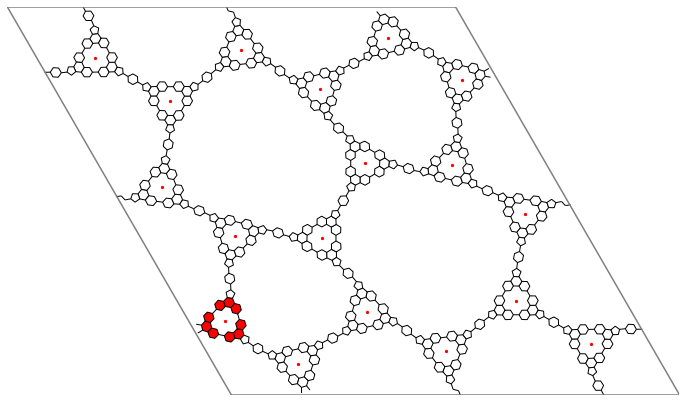

In [4]:
from scipy.spatial import ConvexHull
from matplotlib.path import Path
from matplotlib.patches import PathPatch


fig = plt.figure(figsize=(10,10)) 
ax = fig.add_subplot(111, aspect='equal')

cl2color = {2: 'black', 3: 'green', 5: 'blue', 6: 'red'}
cl2color = {0: 'white', 1: 'black', 2: 'green', 3: 'blue', 4: 'red', 6: 'magenta'}

ps = 0
for i, c in enumerate(cy):
    if (len(c) > 2) and (len(c) <= 6):
        # patch = PathPatch(Path(np.concatenate((s0.positions[c,0:2], s0.positions[c[0:1],0:2]))), fc=cl2color[len(c)])
        pos = s0.positions[c,0:2]
        hull = ConvexHull(pos)        
        # patch = PathPatch(Path(np.concatenate((pos[hull.vertices,0:2], pos[hull.vertices[0:1],0:2]))), fc=cl2color[len(c)])
        
        if i in [mfs[1][n] for n in motif.nodes]:
            patch = PathPatch(Path(np.concatenate((pos[hull.vertices,0:2], pos[hull.vertices[0:1],0:2]))), fc='red')        
        else:
            patch = PathPatch(Path(np.concatenate((pos[hull.vertices,0:2], pos[hull.vertices[0:1],0:2]))), fc='white')        
        
        ax.add_patch(patch)
        ps += 1
    elif len(c) == 2:
        if i in [mfs[1][n] for n in motif.nodes]:
            patch = PathPatch(Path(s0.positions[c,0:2]), fc='red')
        else:
            patch = PathPatch(Path(s0.positions[c,0:2]), fc='white')            
        ax.add_patch(patch)
        # ps += 1

        
plt.scatter(r_c[:,0], r_c[:,1], color='red', s=5)
        
ax.set_ylim((s0.cell.array[:,1].min(),s0.cell.array[:,1].max())) 
ax.set_xlim((s0.cell.array[:,0].min(),s0.cell.array[:,0].max())) 

ax.plot([ 0., s0.cell.array[0,0]], [0., s0.cell.array[0,1]], color='grey')
ax.plot([ 0., s0.cell.array[1,0]], [0., s0.cell.array[1,1]], color='grey')
ax.plot([ s0.cell.array[1,0], s0.cell.array[1,0]+s0.cell.array[0,0]], [s0.cell.array[1,1], s0.cell.array[1,1]+s0.cell.array[0,1]], color='grey')
ax.plot([ s0.cell.array[0,0], s0.cell.array[1,0]+s0.cell.array[0,0]], [s0.cell.array[0,1], s0.cell.array[1,1]+s0.cell.array[0,1]], color='grey')

plt.tight_layout()
plt.axis('off')
plt.show()

In [5]:
all_mfs_cy = [mfs[i]['B'] for i in range(len(mfs))]

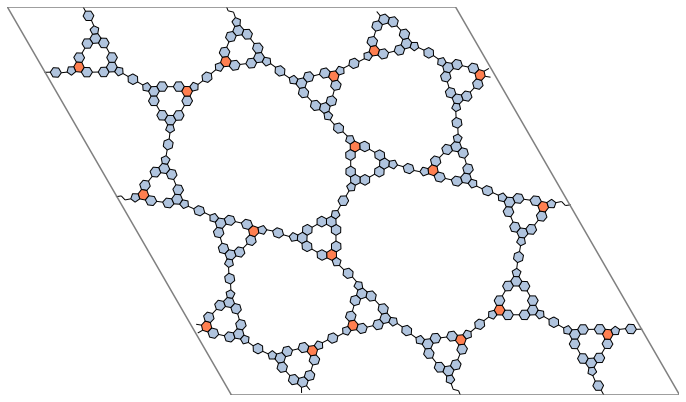

In [6]:
fig = plt.figure(figsize=(10,10)) 
ax = fig.add_subplot(111, aspect='equal')

cl2color = {2: 'black', 3: 'green', 5: 'blue', 6: 'red'}
cl2color = {0: 'white', 1: 'black', 2: 'green', 3: 'blue', 4: 'red', 6: 'magenta'}

ps = 0
for i, c in enumerate(cy):
    if (len(c) > 2) and (len(c) <= 6):
        # patch = PathPatch(Path(np.concatenate((s0.positions[c,0:2], s0.positions[c[0:1],0:2]))), fc=cl2color[len(c)])
        pos = s0.positions[c,0:2]
        hull = ConvexHull(pos)        
        # patch = PathPatch(Path(np.concatenate((pos[hull.vertices,0:2], pos[hull.vertices[0:1],0:2]))), fc=cl2color[len(c)])
        
        if i in all_mfs_cy:
            patch = PathPatch(Path(np.concatenate((pos[hull.vertices,0:2], pos[hull.vertices[0:1],0:2]))), fc='coral')        
        else:
            patch = PathPatch(Path(np.concatenate((pos[hull.vertices,0:2], pos[hull.vertices[0:1],0:2]))), fc='lightsteelblue')        
        
        ax.add_patch(patch)
        ps += 1
    elif len(c) == 2:
        if i in all_mfs_cy:
            patch = PathPatch(Path(s0.positions[c,0:2]), fc='coral')
        else:
            patch = PathPatch(Path(s0.positions[c,0:2]), fc='lightsteelblue')            
        ax.add_patch(patch)
        # ps += 1

        
ax.set_ylim((s0.cell.array[:,1].min(),s0.cell.array[:,1].max())) 
ax.set_xlim((s0.cell.array[:,0].min(),s0.cell.array[:,0].max())) 

ax.plot([ 0., s0.cell.array[0,0]], [0., s0.cell.array[0,1]], color='grey')
ax.plot([ 0., s0.cell.array[1,0]], [0., s0.cell.array[1,1]], color='grey')
ax.plot([ s0.cell.array[1,0], s0.cell.array[1,0]+s0.cell.array[0,0]], [s0.cell.array[1,1], s0.cell.array[1,1]+s0.cell.array[0,1]], color='grey')
ax.plot([ s0.cell.array[0,0], s0.cell.array[1,0]+s0.cell.array[0,0]], [s0.cell.array[0,1], s0.cell.array[1,1]+s0.cell.array[0,1]], color='grey')

plt.tight_layout()
plt.axis('off')
plt.show()
# plt.savefig('COF-5_SW-schematic1.pdf')

In [22]:
def w(x, phi0=0., phi1=0.):
    
    return (x**2 - 2*x + 1)*x*phi0 + (x - 1)*x**2*phi1

x = np.linspace(0,1,20)

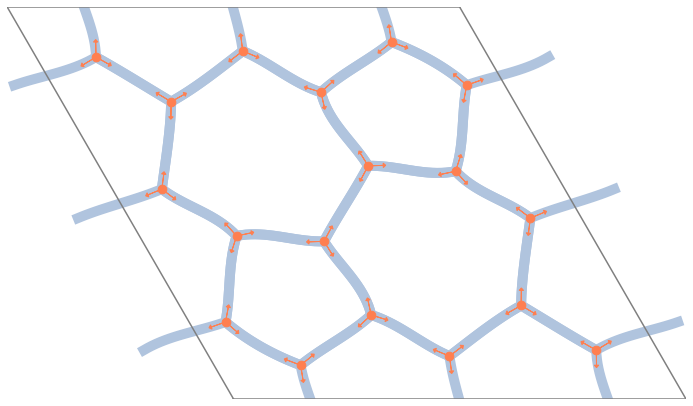

In [23]:
r_c = []
phi_c = []
for m in mfs:
    r_B = G_cy.nodes[m['B']]['pos'].mean(axis=0)
    r_A = G_cy.nodes[m['A']]['pos'].mean(axis=0)
    r_c.append(r_B)
    r_AB = r_A - r_B
    phi_c.append(np.arctan2(r_AB[1], r_AB[0]))
    
r_c = np.array(r_c)
phi_c = np.array(phi_c)

nn_c = []
for i in range(len(r_c)):
#     for j in range(i+1,len(r_c)):
    for j in range(len(r_c)):
        if i != j:
            for s1 in [-1,0,1]:
                for s2 in [-1,0,1]:
                    Rvec = s1 * s0.cell.array[0,:] + s2 * s0.cell.array[1,:]
                    if np.linalg.norm(r_c[i]-r_c[j] - Rvec) < 20.0:
                        nn_c.append([i,j,s1,s2])
#                         print(np.linalg.norm(r_c[i]-r_c[j]))

fig = plt.figure(figsize=(10,10)) 
ax = fig.add_subplot(111, aspect='equal')

ax.scatter(r_c[:,0],r_c[:,1], color='coral', marker='o', s=75, zorder=10)
for i in np.arange(len(r_c)):    
    ax.arrow(r_c[i,0],r_c[i,1], 3*np.cos(phi_c[i]), 3*np.sin(phi_c[i]), color='coral', head_width=0.9, head_length=0.5, zorder=10)
    ax.arrow(r_c[i,0],r_c[i,1], 3*np.cos(phi_c[i]+2*np.pi/3), 3*np.sin(phi_c[i]+2*np.pi/3), color='coral', head_width=0.9, head_length=0.5, zorder=10)
    ax.arrow(r_c[i,0],r_c[i,1], 3*np.cos(phi_c[i]+4*np.pi/3), 3*np.sin(phi_c[i]+4*np.pi/3), color='coral', head_width=0.9, head_length=0.5, zorder=10)


for i in np.arange(len(nn_c)):    
    Rvec = nn_c[i][2] * s0.cell.array[0,:] + nn_c[i][3] * s0.cell.array[1,:]
    
    r_ij = r_c[nn_c[i][1]] - r_c[nn_c[i][0]] + Rvec
    l_ij = np.linalg.norm(r_ij)
    r_ij = r_ij/l_ij
    r_ij_perp = np.cross(np.array([0,0,1.]), r_ij)
    phi_ij = np.mod(np.arctan2(r_ij[1], r_ij[0]), 2*np.pi)

    phi0s = np.array([(phi_c[nn_c[i][0]]-phi_ij),
                   np.mod(phi_c[nn_c[i][0]]+2*np.pi/3, 2*np.pi)-phi_ij, 
                   np.mod(phi_c[nn_c[i][0]]+4*np.pi/3, 2*np.pi)-phi_ij])
    phi0 = phi0s[0]
    if phi0 > np.pi:
        phi0 = phi0 - 2*np.pi

    for p in phi0s:    
        if p > np.pi:
            p = p - 2*np.pi
        if p < -np.pi:
            p = p + 2*np.pi

        if np.abs(p) < np.abs(phi0):
            phi0 = p

    phi1s = np.array([np.mod(phi_c[nn_c[i][1]]+np.pi, 2*np.pi)-phi_ij, 
                   np.mod(phi_c[nn_c[i][1]]+2*np.pi/3+np.pi, 2*np.pi)-phi_ij, 
                   np.mod(phi_c[nn_c[i][1]]+4*np.pi/3+np.pi, 2*np.pi)-phi_ij])
    phi1 = phi1s[0]
    if phi1 > np.pi:
        phi1 = phi1 - 2*np.pi

    for p in phi1s:    
        if p > np.pi:
            p = p - 2*np.pi
        if p < -np.pi:
            p = p + 2*np.pi

        if np.abs(p) < np.abs(phi1):
            phi1 = p
    
    r_bridge = np.array([r_c[nn_c[i][0]] + xi*l_ij*r_ij + w(xi, phi0, phi1)*l_ij*r_ij_perp for xi in x])
    ax.plot(r_bridge[:,0], r_bridge[:,1], color='lightsteelblue', lw=10)

ax.set_ylim((s0.cell.array[:,1].min(),s0.cell.array[:,1].max())) 
ax.set_xlim((s0.cell.array[:,0].min(),s0.cell.array[:,0].max())) 

ax.plot([ 0., s0.cell.array[0,0]], [0., s0.cell.array[0,1]], color='grey')
ax.plot([ 0., s0.cell.array[1,0]], [0., s0.cell.array[1,1]], color='grey')
ax.plot([ s0.cell.array[1,0], s0.cell.array[1,0]+s0.cell.array[0,0]], [s0.cell.array[1,1], s0.cell.array[1,1]+s0.cell.array[0,1]], color='grey')
ax.plot([ s0.cell.array[0,0], s0.cell.array[1,0]+s0.cell.array[0,0]], [s0.cell.array[0,1], s0.cell.array[1,1]+s0.cell.array[0,1]], color='grey')

plt.tight_layout()
plt.axis('off')
plt.show()
#plt.savefig('COF-5_SW-schematic2.pdf')

In [51]:
s0.cell.array[0,:]

array([90.2481003,  0.       ,  0.       ])

## Bond-stretching and Angle-bending Force Field (BAFF)

In [7]:
# old parameters
# BAFF = BAFFPotential(r0=38.762141/np.sqrt(3), cosT0=-0.5, Kbond=64.605495/2, Kangle=147.499900) # Star-COF-1phenyl
# BAFF = BAFFPotential(r0=35.339459/np.sqrt(3), cosT0=-0.5, Kbond=73.646800/2, Kangle=47.933272) # DBA2-COF-1phenyl
# BAFF = BAFFPotential(r0=30.082740/np.sqrt(3), cosT0=-0.5, Kbond=82.016070/2, Kangle=82.519325) # Tp-DB-1phenyl

BAFF = BAFFPotential(r0=38.762111/np.sqrt(3), cosT0=-0.5, Kbond=64.622016/2, Kangle=147.080084) # Star-COF-1phenyl
# BAFF = BAFFPotential(r0=35.339532/np.sqrt(3), cosT0=-0.5, Kbond=73.664306/2, Kangle=47.764008) # DBA2-COF-1phenyl
# BAFF = BAFFPotential(r0=30.082756/np.sqrt(3), cosT0=-0.5, Kbond=82.003030/2, Kangle=82.312490) # Tp-DB-1phenyl

In [8]:
atoms = Atoms(['Y'] * len(r_c), positions=r_c, cell=s0.cell, pbc=True, info={'ffname': 'BAFF'})
# atoms = read('TpDB_COF_1phenyl_SW_BAFF.xyz')

In [9]:
atoms.calc = BAFF

print(atoms.get_potential_energy())

dyn = BFGS(atoms)
dyn.run(fmax=1e-3)

print('\nE_{def} = %3.2f eV' % (atoms.get_potential_energy()*1e-20 * 6.242e18))

424.7218980621596
      Step     Time          Energy         fmax
BFGS:    0 15:10:54      424.721898       52.8054
BFGS:    1 15:10:55      400.355533       31.2705
BFGS:    2 15:10:55      385.452234       18.6816
BFGS:    3 15:10:55      383.370051       26.3027
BFGS:    4 15:10:55      376.417312       18.4500
BFGS:    5 15:10:55      374.904948       26.8152
BFGS:    6 15:10:55      368.077205       14.3917
BFGS:    7 15:10:55      363.811579       15.6404
BFGS:    8 15:10:55      359.941244        8.5306
BFGS:    9 15:10:55      357.533000        6.2554
BFGS:   10 15:10:55      356.164589        4.9350
BFGS:   11 15:10:55      355.783635        4.0129
BFGS:   12 15:10:55      355.683527        2.2661
BFGS:   13 15:10:55      355.652503        3.1098
BFGS:   14 15:10:55      355.827902        6.1856
BFGS:   15 15:10:55      355.613164        0.1942
BFGS:   16 15:10:55      355.613643        0.4963
BFGS:   17 15:10:55      355.613056        0.1870
BFGS:   18 15:10:55      355.6128

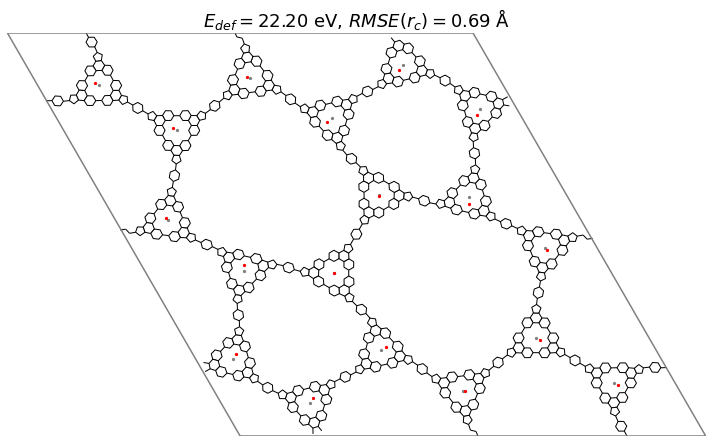

In [12]:
phi0 = _get_phi0(atoms, BAFF.parameters.r0)
phi_c = atoms.get_initial_charges()

fig = plt.figure(figsize=(10,10)) 
ax = fig.add_subplot(111, aspect='equal')

cl2color = {2: 'black', 3: 'green', 5: 'blue', 6: 'red'}
cl2color = {0: 'white', 1: 'black', 2: 'green', 3: 'blue', 4: 'red', 6: 'magenta'}

ps = 0
for i, c in enumerate(cy):
    if (len(c) > 2) and (len(c) <= 6):
        # patch = PathPatch(Path(np.concatenate((s0.positions[c,0:2], s0.positions[c[0:1],0:2]))), fc=cl2color[len(c)])
        pos = s0.positions[c,0:2]
        hull = ConvexHull(pos)        
        # patch = PathPatch(Path(np.concatenate((pos[hull.vertices,0:2], pos[hull.vertices[0:1],0:2]))), fc=cl2color[cy_nn[i]])
        
        if i in [mfs[1][n] for n in motif.nodes]:
            patch = PathPatch(Path(np.concatenate((pos[hull.vertices,0:2], pos[hull.vertices[0:1],0:2]))), fc='white')        
        else:
            patch = PathPatch(Path(np.concatenate((pos[hull.vertices,0:2], pos[hull.vertices[0:1],0:2]))), fc='white')        
        
        ax.add_patch(patch)
        ps += 1
    elif len(c) == 2:
        patch = PathPatch(Path(s0.positions[c,0:2]), fc=cl2color[len(c)])
        ax.add_patch(patch)
        # ps += 1

ax.set_ylim((s0.cell.array[:,1].min(),s0.cell.array[:,1].max())) 
ax.set_xlim((s0.cell.array[:,0].min(),s0.cell.array[:,0].max())) 

ax.plot([ 0., s0.cell.array[0,0]], [0., s0.cell.array[0,1]], color='grey')
ax.plot([ 0., s0.cell.array[1,0]], [0., s0.cell.array[1,1]], color='grey')
ax.plot([ s0.cell.array[1,0], s0.cell.array[1,0]+s0.cell.array[0,0]], [s0.cell.array[1,1], s0.cell.array[1,1]+s0.cell.array[0,1]], color='grey')
ax.plot([ s0.cell.array[0,0], s0.cell.array[1,0]+s0.cell.array[0,0]], [s0.cell.array[0,1], s0.cell.array[1,1]+s0.cell.array[0,1]], color='grey')

# ax.scatter(atoms0.positions[:,0], atoms0.positions[:,1], color='green', s=5, zorder=10)
# for i in np.arange(len(phi_c)):    
#     ax.arrow(atoms.positions[i,0],atoms.positions[i,1], 3*np.cos(phi_c[i]+phi0[i]), 3*np.sin(phi_c[i]+phi0[i]), color='green', head_width=0.9, head_length=0.5,)
#     ax.arrow(atoms.positions[i,0],atoms.positions[i,1], 3*np.cos(phi_c[i]+2*np.pi/3+phi0[i]), 3*np.sin(phi_c[i]+2*np.pi/3+phi0[i]), color='green', head_width=0.9, head_length=0.5,)
#     ax.arrow(atoms.positions[i,0],atoms.positions[i,1], 3*np.cos(phi_c[i]+4*np.pi/3+phi0[i]), 3*np.sin(phi_c[i]+4*np.pi/3+phi0[i]), color='green', head_width=0.9, head_length=0.5,)

ax.scatter(r_c[:,0], r_c[:,1], color='grey', s=5, zorder=10)
ax.scatter(atoms.positions[:,0], atoms.positions[:,1], color='red', s=5, zorder=10)
    
plt.axis('off')
plt.title(r'$E_{def} = %3.2f$ eV, $RMSE(r_{c}) = %3.2f$ Å' % (atoms.get_potential_energy()*1e-20 * 6.242e18, np.std(atoms.positions - r_c)),
         fontsize=18)
plt.tight_layout()
plt.show()
#plt.savefig('Defect_DB/Star_COF_1phenyl_SW_BAFF.pdf')
# plt.savefig('Defect_DB/DBA2_COF_1phenyl_SW_BAFF.pdf')
# plt.savefig('Defect_DB/TpDB_COF_1phenyl_SW_BAFF.pdf')

In [11]:
# write('TpDB_COF_1phenyl_SW_BAFF.xyz', atoms, format='extxyz')
# write('DBA2_COF_1phenyl_SW_BAFF.xyz', atoms, format='extxyz')
# write('Star_COF_1phenyl_SW_BAFF.xyz', atoms, format='extxyz')

## Beam Network Force Field (BNFF)

In [13]:
# old parameters
# Mikado = MikadoPotential(r0=38.762141/np.sqrt(3), cosT0=-0.5, Kbond=64.605495/2, Kangle=147.499900/2) # Star-COF-1phenyl
# Mikado = MikadoPotential(r0=35.339459/np.sqrt(3), cosT0=-0.5, Kbond=73.646800/2, Kangle=47.933272/2) # DBA2-COF-1phenyl
# Mikado = MikadoPotential(r0=30.082740/np.sqrt(3), cosT0=-0.5, Kbond=82.016070/2, Kangle=82.519325/2) # Tp-DB-1phenyl

Mikado = MikadoPotential(r0=38.762111/np.sqrt(3), cosT0=-0.5, Kbond=64.622016/2, Kangle=147.080084/2) # Star-COF-1phenyl
# Mikado = MikadoPotential(r0=35.339532/np.sqrt(3), cosT0=-0.5, Kbond=73.664306/2, Kangle=47.764008/2) # DBA2-COF-1phenyl
# Mikado = MikadoPotential(r0=30.082756/np.sqrt(3), cosT0=-0.5, Kbond=82.003030/2, Kangle=82.312490/2) # Tp-DB-1phenyl

In [14]:
atoms = Atoms(['Y'] * len(r_c), positions=r_c, cell=s0.cell, pbc=True, info={'ffname': 'BNFF'})
# atoms = read('TpDB_COF_1phenyl_SW_BNFF.xyz')
atoms.calc = Mikado

atoms.get_potential_energy()

560.9859079593721

In [15]:
pos0 = atoms.get_positions().flatten()
ch0 = atoms.get_initial_charges()

res_tot = minimize(_energy_total, np.concatenate((ch0, pos0)), args=(atoms,), options={'disp': True, 'maxiter': 100, 'gtol': 1e-3})

print('\nE_{def} = %3.2f eV' % (atoms.get_potential_energy()*1e-20 * 6.242e18))

Optimization terminated successfully.
         Current function value: 316.456065
         Iterations: 65
         Function evaluations: 6716
         Gradient evaluations: 92

E_{def} = 19.75 eV


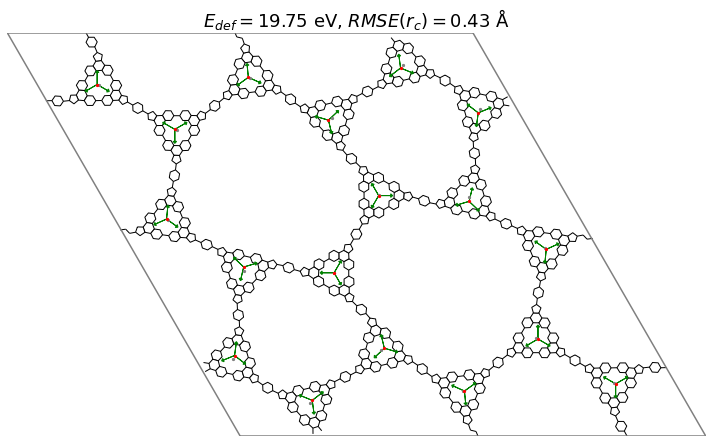

In [16]:
phi0 = _get_phi0(atoms, Mikado.parameters.r0)
phi_c = atoms.get_initial_charges()

fig = plt.figure(figsize=(10,10)) 
ax = fig.add_subplot(111, aspect='equal')

cl2color = {2: 'black', 3: 'green', 5: 'blue', 6: 'red'}
cl2color = {0: 'white', 1: 'black', 2: 'green', 3: 'blue', 4: 'red', 6: 'magenta'}

ps = 0
for i, c in enumerate(cy):
    if (len(c) > 2) and (len(c) <= 6):
        # patch = PathPatch(Path(np.concatenate((s0.positions[c,0:2], s0.positions[c[0:1],0:2]))), fc=cl2color[len(c)])
        pos = s0.positions[c,0:2]
        hull = ConvexHull(pos)        
        # patch = PathPatch(Path(np.concatenate((pos[hull.vertices,0:2], pos[hull.vertices[0:1],0:2]))), fc=cl2color[cy_nn[i]])
        
        if i in [mfs[1][n] for n in motif.nodes]:
            patch = PathPatch(Path(np.concatenate((pos[hull.vertices,0:2], pos[hull.vertices[0:1],0:2]))), fc='white')        
        else:
            patch = PathPatch(Path(np.concatenate((pos[hull.vertices,0:2], pos[hull.vertices[0:1],0:2]))), fc='white')        
        
        ax.add_patch(patch)
        ps += 1
    elif len(c) == 2:
        patch = PathPatch(Path(s0.positions[c,0:2]), fc=cl2color[len(c)])
        ax.add_patch(patch)
        # ps += 1

ax.set_ylim((s0.cell.array[:,1].min(),s0.cell.array[:,1].max())) 
ax.set_xlim((s0.cell.array[:,0].min(),s0.cell.array[:,0].max())) 

ax.plot([ 0., s0.cell.array[0,0]], [0., s0.cell.array[0,1]], color='grey')
ax.plot([ 0., s0.cell.array[1,0]], [0., s0.cell.array[1,1]], color='grey')
ax.plot([ s0.cell.array[1,0], s0.cell.array[1,0]+s0.cell.array[0,0]], [s0.cell.array[1,1], s0.cell.array[1,1]+s0.cell.array[0,1]], color='grey')
ax.plot([ s0.cell.array[0,0], s0.cell.array[1,0]+s0.cell.array[0,0]], [s0.cell.array[0,1], s0.cell.array[1,1]+s0.cell.array[0,1]], color='grey')

# ax.scatter(atoms0.positions[:,0], atoms0.positions[:,1], color='green', s=5, zorder=10)
for i in np.arange(len(phi_c)):    
    ax.arrow(atoms.positions[i,0],atoms.positions[i,1], 3*np.cos(phi_c[i]+phi0[i]), 3*np.sin(phi_c[i]+phi0[i]), color='green', head_width=0.9, head_length=0.5,)
    ax.arrow(atoms.positions[i,0],atoms.positions[i,1], 3*np.cos(phi_c[i]+2*np.pi/3+phi0[i]), 3*np.sin(phi_c[i]+2*np.pi/3+phi0[i]), color='green', head_width=0.9, head_length=0.5,)
    ax.arrow(atoms.positions[i,0],atoms.positions[i,1], 3*np.cos(phi_c[i]+4*np.pi/3+phi0[i]), 3*np.sin(phi_c[i]+4*np.pi/3+phi0[i]), color='green', head_width=0.9, head_length=0.5,)

ax.scatter(r_c[:,0], r_c[:,1], color='grey', s=5, zorder=10)
ax.scatter(atoms.positions[:,0], atoms.positions[:,1], color='red', s=5, zorder=10)
    
plt.axis('off')
plt.title(r'$E_{def} = %3.2f$ eV, $RMSE(r_{c}) = %3.2f$ Å' % (atoms.get_potential_energy()*1e-20 * 6.242e18, np.std(atoms.positions - r_c)),
         fontsize=18)
plt.tight_layout()
# plt.show()
# plt.savefig('Defect_DB/Star_COF_1phenyl_SW_Mikado.pdf')
# plt.savefig('Defect_DB/DBA2_COF_1phenyl_SW_Mikado.pdf')
# plt.savefig('Defect_DB/TpDB_COF_1phenyl_SW_Mikado.pdf')

In [17]:
# write('TpDB_COF_1phenyl_SW_BNFF.xyz', atoms, format='extxyz')
# write('Star_COF_1phenyl_SW_BNFF.xyz', atoms, format='extxyz')

# Results for all COFs

In [60]:
import pandas as pd

In [72]:
defres=[]

defres.append({'name': 'Tp DB_1phenyl', 'ffname': 'DFTB', 'Edef [eV]': 12.66})
defres.append({'name': 'Tp DB_1phenyl', 'ffname': 'BAFF', 'Edef [eV]': 12.75, 'RMSE(r_{c}) [A]': 0.36})
defres.append({'name': 'Tp DB_1phenyl', 'ffname': 'Mikado', 'Edef [eV]': 11.45, 'RMSE(r_{c}) [A]': 0.19})

defres.append({'name': 'DBA2 1phenyl', 'ffname': 'DFTB', 'Edef [eV]': 11.27})
defres.append({'name': 'DBA2 1phenyl', 'ffname': 'BAFF', 'Edef [eV]': 7.99, 'RMSE(r_{c}) [A]': 0.45})
defres.append({'name': 'DBA2 1phenyl', 'ffname': 'Mikado', 'Edef [eV]': 7.32, 'RMSE(r_{c}) [A]': 0.24})

defres.append({'name': 'Star_COF 1phenyl', 'ffname': 'DFTB', 'Edef [eV]': 24.06})
defres.append({'name': 'Star_COF 1phenyl', 'ffname': 'BAFF', 'Edef [eV]': 22.25, 'RMSE(r_{c}) [A]': 0.45})
defres.append({'name': 'Star_COF 1phenyl', 'ffname': 'Mikado', 'Edef [eV]': 19.8, 'RMSE(r_{c}) [A]': 0.24})

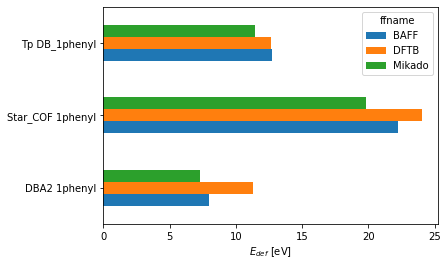

In [76]:
df = pd.DataFrame(defres)
# df.drop(columns=[ 'RMSE(r_{c}) [A]'], inplace=True)

df.pivot('name', 'ffname', 'Edef [eV]').plot(kind='barh')
plt.gca().set_ylabel('')
plt.gca().set_xlabel(r'$E_{def}$ [eV]')
plt.show()

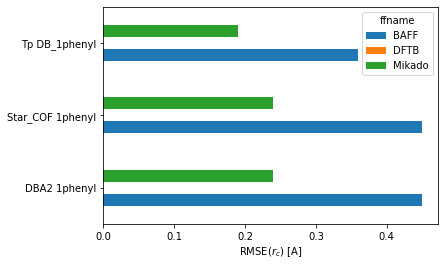

In [78]:
df.pivot('name', 'ffname', 'RMSE(r_{c}) [A]').plot(kind='barh')
plt.gca().set_ylabel('')
plt.gca().set_xlabel(r'RMSE($r_{c}$) [A]')
plt.show()